# Pyspark ETL

## Processamento inicial dos dados

In [28]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import to_date

In [29]:
# Configurar variáveis para acessar HDFS (caso necessário)
os.environ["HADOOP_USER_NAME"] = "root"  # executa operações no HDFS como usuário root

In [30]:
# Iniciar sessão Spark
spark = SparkSession.builder \
    .appName("SiasusETL") \
    .getOrCreate()

In [31]:
# Ler o arquivo CSV do HDFS
# vamos definir esquemas manualmente em alguns casos
# encoding Latin-1 para caracteres especiais
df = spark.read.format("csv") \
    .option("header", True) \
    .option("inferSchema", False) \
    .option("sep", ",") \
    .option("encoding", "ISO-8859-1") \
    .load("hdfs://localhost:9000/user/root/siasus/PSRS2301.csv")

In [32]:
df.printSchema()
df.show(5)

root
 |-- CNES_EXEC: string (nullable = true)
 |-- GESTAO: string (nullable = true)
 |-- CONDIC: string (nullable = true)
 |-- UFMUN: string (nullable = true)
 |-- TPUPS: string (nullable = true)
 |-- TIPPRE  : string (nullable = true)
 |-- MN_IND: string (nullable = true)
 |-- CNPJCPF: string (nullable = true)
 |-- CNPJMNT: string (nullable = true)
 |-- DT_PROCESS: string (nullable = true)
 |-- DT_ATEND: string (nullable = true)
 |-- CNS_PAC: string (nullable = true)
 |-- DTNASC: string (nullable = true)
 |-- TPIDADEPAC: string (nullable = true)
 |-- IDADEPAC: string (nullable = true)
 |-- NACION_PAC: string (nullable = true)
 |-- SEXOPAC: string (nullable = true)
 |-- RACACOR: string (nullable = true)
 |-- ETNIA: string (nullable = true)
 |-- MUNPAC: string (nullable = true)
 |-- MOT_COB: string (nullable = true)
 |-- DT_MOTCOB: string (nullable = true)
 |-- CATEND: string (nullable = true)
 |-- CIDPRI: string (nullable = true)
 |-- CIDASSOC: string (nullable = true)
 |-- ORIGEM_PAC:

In [33]:
from pyspark.sql.functions import col, trim, upper, when

# Exemplo 1: Renomear coluna com espaços e normalizar strings
df = df.withColumnRenamed("TIPPRE  ", "TIPPRE")  # remove espaços do nome da coluna
df = df.withColumn("CONDIC", upper(trim(col("CONDIC"))))  # normaliza CONDIC para maiúsculo sem espaços extras

# Exemplo 2: Converter tipos de dados
df = df.withColumn("IDADEPAC", col("IDADEPAC").cast(IntegerType()))
df = df.withColumn("PA_QTDPRO", col("PA_QTDPRO").cast(IntegerType()))
df = df.withColumn("PA_QTDAPR", col("PA_QTDAPR").cast(IntegerType()))

df = df.withColumn(
    "DTNASC",                      
    to_date(col("DTNASC"), "yyyyMMdd") 
)

# Exemplo 3: Filtrar registros inválidos (caso IDADEPAC não seja plausível, por ex: > 120 anos ou < 0)
df = df.filter((col("IDADEPAC") >= 0) & (col("IDADEPAC") < 120))

# Exemplo 4: Enriquecimento - criar faixa etária
df = df.withColumn(
    "FAIXA_ETARIA",
    when(col("IDADEPAC") < 18, "MENOR")
     .when((col("IDADEPAC") >= 18) & (col("IDADEPAC") < 60), "MAIOR")
     .when(col("IDADEPAC") >= 60, "IDOSO")
)

In [34]:
# Salvar DataFrame tratado no HDFS como Parquet (Camada Silver)
output_path = "hdfs://localhost:9000/user/hadoop/prata/psicossociais"
df.write.mode("overwrite").parquet(output_path)


In [35]:
df_silver = spark.read.parquet(output_path)
df_silver.show(5)


+---------+------+------+------+-----+------+------+--------------+--------------+----------+--------+---------------+----------+----------+--------+----------+-------+-------+-----+------+-------+---------+------+------+--------+----------+---------+------+-------+--------+----------+----------+---------+---------+------+----------+-------+--------+----------+--------+--------+--------+------+------+-------+------------+
|CNES_EXEC|GESTAO|CONDIC| UFMUN|TPUPS|TIPPRE|MN_IND|       CNPJCPF|       CNPJMNT|DT_PROCESS|DT_ATEND|        CNS_PAC|    DTNASC|TPIDADEPAC|IDADEPAC|NACION_PAC|SEXOPAC|RACACOR|ETNIA|MUNPAC|MOT_COB|DT_MOTCOB|CATEND|CIDPRI|CIDASSOC|ORIGEM_PAC|DT_INICIO|DT_FIM|COB_ESF|CNES_ESF|DESTINOPAC|PA_PROC_ID|PA_QTDPRO|PA_QTDAPR|PA_SRV|PA_CLASS_S|SIT_RUA|TP_DROGA|LOC_REALIZ|  INICIO|     FIM|PERMANEN|QTDATE|QTDPCN|NAT_JUR|FAIXA_ETARIA|
+---------+------+------+------+-----+------+------+--------------+--------------+----------+--------+---------------+----------+----------+--------

In [36]:
# df.summary().show()

In [37]:
json_rdd = df_silver.toJSON().collect()

print(f"Total de registros a enviar: {len(json_rdd)}")
print("Exemplo de registro JSON:", json_rdd[0])

Total de registros a enviar: 82233
Exemplo de registro JSON: {"CNES_EXEC":"9573313","GESTAO":"432110","CONDIC":"PG","UFMUN":"432110","TPUPS":"70","TIPPRE":"00","MN_IND":"M","CNPJCPF":"88811948000178","CNPJMNT":"88811948000178","DT_PROCESS":"202301","DT_ATEND":"202301","CNS_PAC":"é{Ç{{äâ~}{üÇ~","DTNASC":"1969-11-27","TPIDADEPAC":"4","IDADEPAC":51,"NACION_PAC":"01","SEXOPAC":"F","RACACOR":"01","MUNPAC":"432110","MOT_COB":"28","CATEND":"01","CIDPRI":"F323","CIDASSOC":"F323","ORIGEM_PAC":"02","DT_INICIO":"20210121","COB_ESF":"S","CNES_ESF":"9573313","DESTINOPAC":"00","PA_PROC_ID":"0301080208","PA_QTDPRO":1,"PA_QTDAPR":1,"PA_SRV":"115","PA_CLASS_S":"002","SIT_RUA":"N","LOC_REALIZ":"C","INICIO":"20230101","FIM":"20230131","PERMANEN":"31","QTDATE":"1","QTDPCN":"1","NAT_JUR":"1244","FAIXA_ETARIA":"MAIOR"}


## Producer

In [38]:
from kafka import KafkaProducer

In [39]:
# Configura o produtor Kafka (envio de strings, então usaremos encoding de UTF-8)
producer = KafkaProducer(bootstrap_servers=['localhost:9092'], 
                         value_serializer=lambda v: v.encode('utf-8'))

In [40]:
topic_name = "atendimentos_psicossociais"

# Envia cada mensagem JSON para o tópico
for record in json_rdd:
    producer.send(topic_name, value=record)

In [41]:
# Força envio de qualquer mensagem pendente
producer.flush()
producer.close()

In [42]:
print(f"{len(json_rdd)} mensagens enviadas para o tópico '{topic_name}'.")

82233 mensagens enviadas para o tópico 'atendimentos_psicossociais'.


docker exec -it kafka bash
kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic andimentos_psicossociais --from-beginning


## Consumer

In [43]:
from kafka import KafkaConsumer
from pymongo import MongoClient
import json
import time

topic_name = "atendimentos_psicossociais"

mongo_client = MongoClient("localhost", 27017)
db = mongo_client["siasus"]
collection = db["atendimentos"]

consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id="grupo-siasus-1",
    value_deserializer=lambda v: v.decode('utf-8')
)

batch_size = 10000
batch = []
count = 0

# Controla tempo sem mensagens
max_empty_polls = 10
empty_polls = 0

try:
    while True:
        raw_msgs = consumer.poll(timeout_ms=1000)  # 1 segundo esperando mensagens

        if not raw_msgs:
            empty_polls += 1
            if empty_polls >= max_empty_polls:
                print("Nenhuma mensagem nova após várias tentativas, encerrando consumo...")
                break
            continue
        else:
            empty_polls = 0  # reset se chegou mensagem

        for tp, messages in raw_msgs.items():
            for msg in messages:
                registro = json.loads(msg.value)
                batch.append(registro)
                count += 1

                if len(batch) >= batch_size:
                    collection.insert_many(batch)
                    print(f"Inseridos {count} registros (último batch de {len(batch)})...")
                    batch.clear()

except KeyboardInterrupt:
    print("Interrupção manual. Finalizando...")

finally:
    if batch:
        collection.insert_many(batch)
        print(f"Inseridos {count} registros (último batch incompleto de {len(batch)})...")

    print(f"Consumo finalizado. Total de registros inseridos: {count}")


Inseridos 10000 registros (último batch de 10000)...
Inseridos 20000 registros (último batch de 10000)...
Inseridos 30000 registros (último batch de 10000)...
Inseridos 40000 registros (último batch de 10000)...
Inseridos 50000 registros (último batch de 10000)...
Inseridos 60000 registros (último batch de 10000)...
Inseridos 70000 registros (último batch de 10000)...
Inseridos 80000 registros (último batch de 10000)...
Nenhuma mensagem nova após várias tentativas, encerrando consumo...
Inseridos 82233 registros (último batch incompleto de 2233)...
Consumo finalizado. Total de registros inseridos: 82233


In [44]:
print(collection.count_documents({}))
# ou, para ver um exemplo de documento:
doc = collection.find_one()
print(doc)

1199190
{'_id': ObjectId('682fd75812ba704a50174c3b'), 'CNES_EXEC': '9573313', 'GESTAO': '432110', 'CONDIC': 'PG', 'UFMUN': '432110', 'TPUPS': '70', 'TIPPRE': '00', 'MN_IND': 'M', 'CNPJCPF': '88811948000178', 'CNPJMNT': '88811948000178', 'DT_PROCESS': '202301', 'DT_ATEND': '202301', 'CNS_PAC': 'é{Ç{{äâ\x7f\x7f~}{üÇ~', 'DTNASC': '1969-11-27', 'TPIDADEPAC': '4', 'IDADEPAC': 51, 'NACION_PAC': '01', 'SEXOPAC': 'F', 'RACACOR': '01', 'MUNPAC': '432110', 'MOT_COB': '28', 'CATEND': '01', 'CIDPRI': 'F323', 'CIDASSOC': 'F323', 'ORIGEM_PAC': '02', 'DT_INICIO': '20210121', 'COB_ESF': 'S', 'CNES_ESF': '9573313', 'DESTINOPAC': '00', 'PA_PROC_ID': '0301080208', 'PA_QTDPRO': 1, 'PA_QTDAPR': 1, 'PA_SRV': '115', 'PA_CLASS_S': '002', 'SIT_RUA': 'N', 'LOC_REALIZ': 'C', 'INICIO': '20230101', 'FIM': '20230131', 'PERMANEN': '31', 'QTDATE': '1', 'QTDPCN': '1', 'NAT_JUR': '1244', 'FAIXA_ETARIA': 'MAIOR'}


## Análise exploratória

In [45]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt

In [46]:
docs = list(collection.find({}).limit(41117))


In [47]:
df_pd = pd.DataFrame(docs)

print(df_pd.shape)        # deve ser (82233, número_de_colunas+_id)
print(df_pd.columns[:10]) # ver as primeiras colunas disponíveis

(41117, 47)
Index(['_id', 'CNES_EXEC', 'GESTAO', 'CONDIC', 'UFMUN', 'TPUPS', 'TIPPRE',
       'MN_IND', 'CNPJCPF', 'CNPJMNT'],
      dtype='object')


### Distribuição do número de atendimentos psicossociais por sexo do paciente em Jan/2023

In [48]:
#Distribuição por sexo dos pacientes: Quantos atendimentos foram para pacientes do sexo masculino vs feminino? Isso pode indicar perfil demográfico do atendimento psicossocial.
contagem_sexo = df_pd['SEXOPAC'].value_counts()
porcentagem_sexo = df_pd['SEXOPAC'].value_counts(normalize=True) * 100

distribuicao_sexo = pd.DataFrame({
    'Quantidade': contagem_sexo,
    'Porcentagem (%)': porcentagem_sexo
})

print(distribuicao_sexo)

         Quantidade  Porcentagem (%)
SEXOPAC                             
M             23269        56.592164
F             17848        43.407836


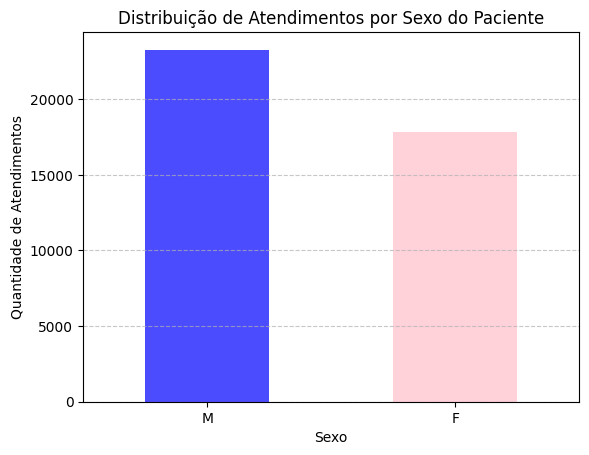

In [49]:
# Criar o gráfico de barras
contagem_sexo.plot(kind='bar', color=['blue', 'pink'], alpha=0.7)

# Configurar o gráfico
plt.title("Distribuição de Atendimentos por Sexo do Paciente")
plt.xlabel("Sexo")
plt.ylabel("Quantidade de Atendimentos")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

### Atendimentos por faixa etária

In [50]:
# Distribuição por faixa etária: Quantos atendimentos foram para cada faixa etária?
contagem_faixa_etaria = df_pd['FAIXA_ETARIA'].value_counts()
porcentagem_faixa_etaria = df_pd['FAIXA_ETARIA'].value_counts(normalize=True) * 100

distribuicao_faixa_etaria = pd.DataFrame({
    'Quantidade': contagem_faixa_etaria,
    'Porcentagem (%)': porcentagem_faixa_etaria
})

print(distribuicao_faixa_etaria)

              Quantidade  Porcentagem (%)
FAIXA_ETARIA                             
MAIOR              28538        69.406815
MENOR              10382        25.249897
IDOSO               2197         5.343289


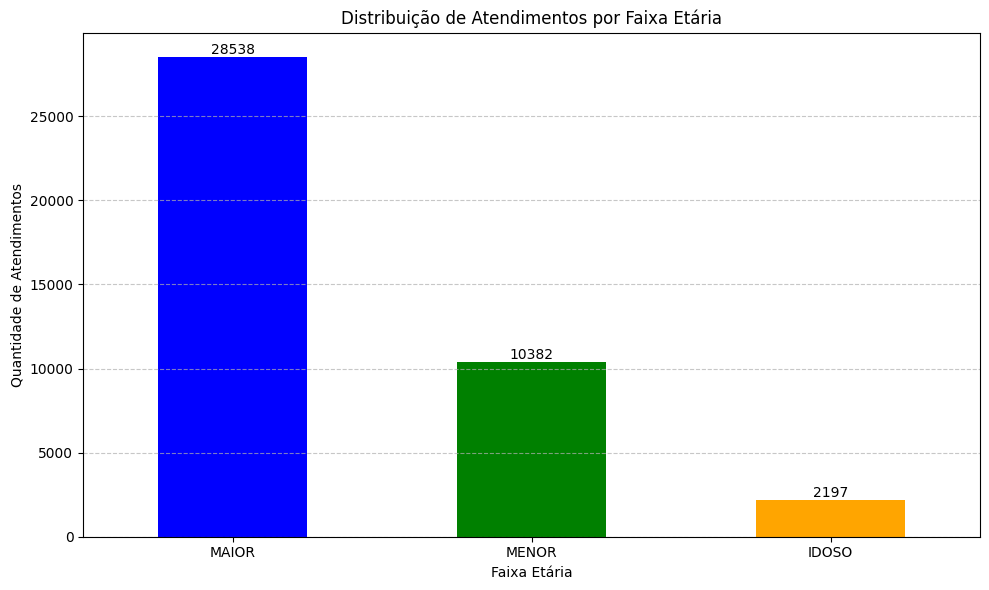

In [51]:
# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
contagem_faixa_etaria.plot(kind='bar', color=['blue', 'green', 'orange'])

# Configurar o gráfico
plt.title("Distribuição de Atendimentos por Faixa Etária")
plt.xlabel("Faixa Etária")
plt.ylabel("Quantidade de Atendimentos")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores sobre as barras
for i, v in enumerate(contagem_faixa_etaria):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

### Diagnósticos mais frequentes

In [52]:
# Número de top CIDs a exibir
num_top_cids = 5

# Contar a frequência de cada CID
contagem_cids = df_pd['CIDPRI'].value_counts()

# Calcular as porcentagens
porcentagem_cids = contagem_cids / contagem_cids.sum() * 100

# Selecionar os top CIDs
top_cids_count = contagem_cids.head(num_top_cids)
top_cids_percent = porcentagem_cids.head(num_top_cids)

# Calcular valores para "Outros"
count_outros = contagem_cids.sum() - top_cids_count.sum()
percent_outros = 100 - top_cids_percent.sum()

# Criar DataFrame com os resultados
distribuicao_cids = pd.DataFrame({
    'CID': list(top_cids_count.index) + ['Outros'],
    'Quantidade': list(top_cids_count.values) + [count_outros],
    'Porcentagem (%)': list(top_cids_percent.values) + [percent_outros]
})

# Formatar a coluna de porcentagem para 2 casas decimais
distribuicao_cids['Porcentagem (%)'] = distribuicao_cids['Porcentagem (%)'].round(2)

print(distribuicao_cids)

      CID  Quantidade  Porcentagem (%)
0     F99        8332            20.26
1    F102        4119            10.02
2     F19        4062             9.88
3    F192        3551             8.64
4     F20         978             2.38
5  Outros       20075            48.82


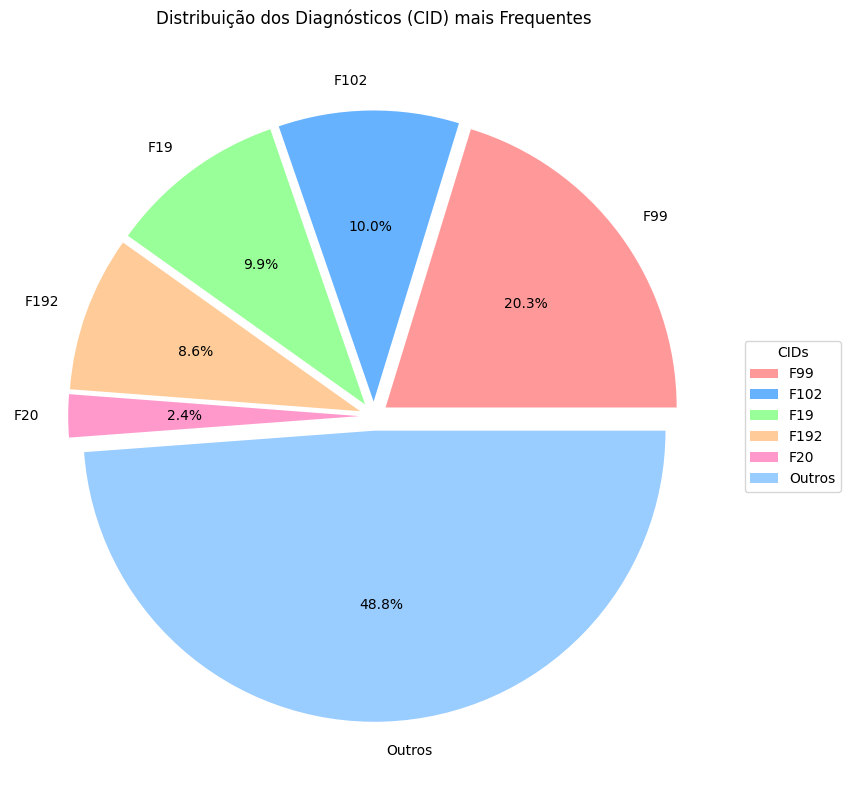

In [53]:
# Criar figura com tamanho personalizado
plt.figure(figsize=(10, 8))

# Criar gráfico de pizza
plt.pie(distribuicao_cids['Quantidade'], 
        labels=distribuicao_cids['CID'],
        autopct='%1.1f%%',
        colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF'],
        explode=[0.05] * len(distribuicao_cids))  # pequena separação de todas as fatias

# Adicionar título
plt.title('Distribuição dos Diagnósticos (CID) mais Frequentes', pad=20)

# Adicionar legenda
plt.legend(distribuicao_cids['CID'], 
          title="CIDs",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Ajustar layout para não cortar a legenda
plt.tight_layout()

# Mostrar o gráfico
plt.show()

### Estabelecimentos e municípios

In [54]:
print("Estabelecimentos únicos (CNES_EXEC):", df_pd['CNES_EXEC'].nunique())
print("Municípios únicos (MUNPAC):", df_pd['MUNPAC'].nunique())

Estabelecimentos únicos (CNES_EXEC): 77
Municípios únicos (MUNPAC): 88
